Currently:
* training the original network (500-500-2000-2) on mnist with tsne loss
* training the original network on a pre-embedded set of 2d points with mse loss
* training a convolution net on a pre-embedded set of 2d points with mse loss

Next:
* check tsne loss on test set for all three models
* if we lower the learning rate in response to test set loss can we acheive lower final loss?
* what architecture allows us to minimize the number of parameters while also minimizing test tsne loss?
* does dropout have an effect on the generalization of any of the models?
* can we "deep dream" a point in 2d space to recover an input that produces it?
* what happens if we permute the input data but use the same joint probabilities?
* what if we instead use P from an unsupervised mid-dimensional representation like an autoencoder or VAE? (e.g., 48D)
* what if we use t-SNE loss as a contributing cost function to an autoencoder?

In [1]:
import os
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=gpu0,lib.cnmem=1'

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.datasets import mnist

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled)


In [2]:
batch_size = 5000

%time (X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

CPU times: user 960 ms, sys: 123 ms, total: 1.08 s
Wall time: 1.08 s
(60000, 'train samples')
(10000, 'test samples')


In [3]:
def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(np.multiply(D, P)) / sumP
    P = P / sumP
    return H, P

def x2p(X, u=15, tol=1e-4, print_iter=500, max_tries=50, verbose=0):
    # Initialize some variables
    n = X.shape[0]                     # number of instances
    P = np.zeros((n, n))               # empty probability matrix
    beta = np.ones(n)                  # empty precision vector
    logU = np.log(u)                   # log of perplexity (= entropy)
    
    # Compute pairwise distances
    if verbose > 0: print('Computing pairwise distances...')
    sum_X = np.sum(np.square(X), axis=1)
    # note: translating sum_X' from matlab to numpy means using reshape to add a dimension
    D = sum_X + sum_X[:,None] + -2 * X.dot(X.T)

    # Run over all datapoints
    if verbose > 0: print('Computing P-values...')
    for i in range(n):
        
        if verbose > 1 and print_iter and i % print_iter == 0:
            print('Computed P-values {} of {} datapoints...'.format(i, n))
        
        # Set minimum and maximum values for precision
        betamin = float('-inf')
        betamax = float('+inf')
        
        # Compute the Gaussian kernel and entropy for the current precision
        indices = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
        Di = D[i, indices]
        H, thisP = Hbeta(Di, beta[i])
        
        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:
            
            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i]
                if np.isinf(betamax):
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i]
                if np.isinf(betamin):
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            
            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        # Set the final row of P
        P[i, indices] = thisP
        
    if verbose > 0: 
        print('Mean value of sigma: {}'.format(np.mean(np.sqrt(1 / beta))))
        print('Minimum value of sigma: {}'.format(np.min(np.sqrt(1 / beta))))
        print('Maximum value of sigma: {}'.format(np.max(np.sqrt(1 / beta))))
    
    return P, beta

def compute_joint_probabilities(samples, batch_size=5000, d=2, perplexity=30, tol=1e-5, verbose=0):
    v = d - 1
    
    # Initialize some variables
    n = samples.shape[0]
    batch_size = min(batch_size, n)
    
    # Precompute joint probabilities for all batches
    if verbose > 0: print('Precomputing P-values...')
    batch_count = int(n / batch_size)
    P = np.zeros((batch_count, batch_size, batch_size))
    for i, start in enumerate(range(0, n - batch_size + 1, batch_size)):   
        curX = samples[start:start+batch_size]                   # select batch
        P[i], beta = x2p(curX, perplexity, tol, verbose=verbose) # compute affinities using fixed perplexity
        P[i][np.isnan(P[i])] = 0                                 # make sure we don't have NaN's
        P[i] = (P[i] + P[i].T) # / 2                             # make symmetric
        P[i] = P[i] / P[i].sum()                                 # obtain estimation of joint probabilities
        P[i] = np.maximum(P[i], np.finfo(P[i].dtype).eps)

    return P

In [4]:
%time P = compute_joint_probabilities(X_train, batch_size=batch_size, verbose=2)

Precomputing P-values...
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-values 3500 of 5000 datapoints...
Computed P-values 4000 of 5000 datapoints...
Computed P-values 4500 of 5000 datapoints...
Mean value of sigma: 2.21039589672
Minimum value of sigma: 1.14651898224
Maximum value of sigma: 3.42356224164
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...

In [5]:
%time np.save('P.npy', P)
# %time P = np.load('P.npy')

CPU times: user 3.35 ms, sys: 1.5 s, total: 1.51 s
Wall time: 12.8 s


In [6]:
# P is the joint probabilities for this batch (Keras loss functions call this y_true)
# activations is the low-dimensional output (Keras loss functions call this y_pred)
def tsne(P, activations):
#     d = K.shape(activations)[1]
    d = 2 # TODO: should set this automatically, but the above is very slow for some reason
    n = batch_size # TODO: should set this automatically
    v = d - 1.
    eps = K.variable(10e-15) # needs to be at least 10e-8 to get anything after Q /= K.sum(Q)
    sum_act = K.sum(K.square(activations), axis=1)
    Q = K.reshape(sum_act, [-1, 1]) + -2 * K.dot(activations, K.transpose(activations))
    Q = (sum_act + Q) / v
    Q = K.pow(1 + Q, -(v + 1) / 2)
    Q *= K.variable(1 - np.eye(n))
    Q /= K.sum(Q)
    Q = K.maximum(Q, eps)
    C = K.log((P + eps) / (Q + eps))
    C = K.sum(P * C)
    return C

In [7]:
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(500, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(2))
sgd = SGD(lr=0.1)
%time model.compile(loss=tsne, optimizer=sgd)

CPU times: user 2.29 s, sys: 334 ms, total: 2.62 s
Wall time: 5.42 s


In [8]:
Y_train = P.reshape(X_train.shape[0], -1)
print(X_train.shape)
print(Y_train.shape)

(60000, 784)
(60000, 5000)


In [ ]:
%time model.fit(X_train, Y_train, batch_size=batch_size, shuffle=False, nb_epoch=100)

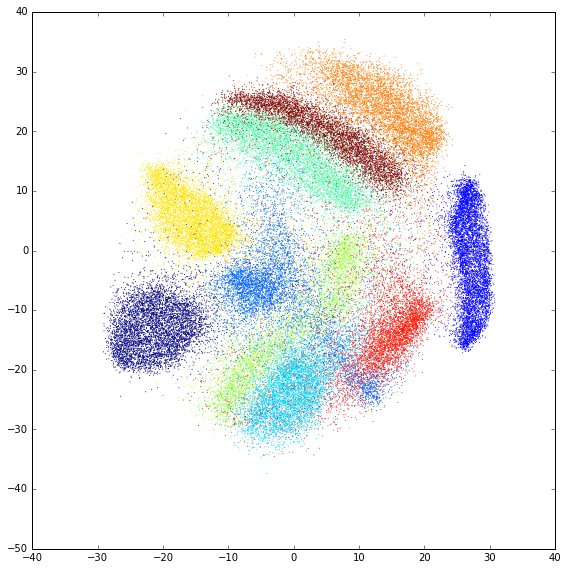

In [10]:
def plot_model(model, data, labels):
    embedding = model.predict(data)
    fig = plt.figure(figsize=(8,8))
    plt.scatter(embedding[:,0], embedding[:,1], marker='o', s=1, edgecolor='', c=labels)
    fig.tight_layout()
plot_model(model, X_train, y_train)

In [11]:
from tsne import bh_sne
%time X_2d = bh_sne(X_train.astype(np.float64))

CPU times: user 17min 42s, sys: 1.71 s, total: 17min 44s
Wall time: 17min 42s


In [12]:
%time np.save('X_2d.npy', X_2d)
# %time X_2d = np.load('X_2d.npy')
X_2d.shape

CPU times: user 393 µs, sys: 721 µs, total: 1.11 ms
Wall time: 720 µs


(60000, 2)

In [ ]:
# around 1.2M parameters
transfer = Sequential()
transfer.add(Dense(500, activation='relu', input_shape=(X_train.shape[1],)))
transfer.add(Dense(500, activation='relu'))
transfer.add(Dense(2000, activation='relu'))
transfer.add(Dense(2))
%time transfer.compile(loss='mean_squared_error', optimizer='rmsprop')

CPU times: user 2.4 s, sys: 551 ms, total: 2.95 s
Wall time: 52.6 s


In [ ]:
%time transfer.fit(X_train, X_2d, nb_epoch=100)

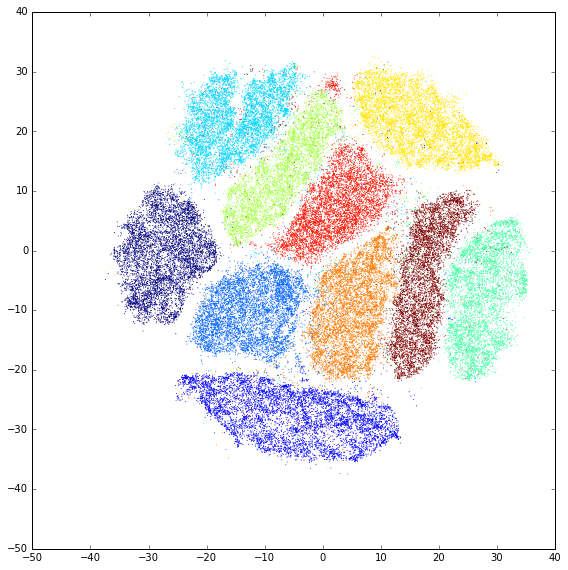

In [21]:
plot_model(transfer, X_train, y_train)

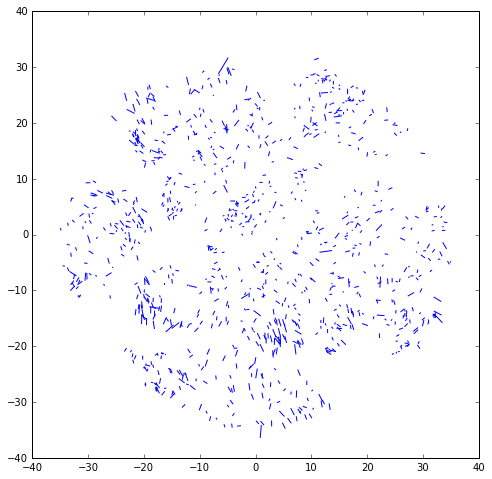

In [22]:
from matplotlib.lines import Line2D
def plot_differences(model, data, actual, lim=1000):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    embedding = model.predict(data)
    for a, b in zip(embedding, actual)[:lim]:
        ax.add_line(Line2D((a[0], b[0]), (a[1], b[1]), linewidth=1))
    ax.autoscale_view()
    plt.show()
plot_differences(transfer, X_train, X_2d)

In [ ]:
# around 600K parameters
nb_filters = 32
nb_pool = 2
nb_conv = 3
conv = Sequential()
conv.add(Convolution2D(nb_filters, nb_conv, nb_conv, input_shape=(1, 28, 28)))
conv.add(Activation('relu'))
conv.add(Convolution2D(nb_filters, nb_conv, nb_conv))
conv.add(Activation('relu'))
conv.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
conv.add(Dropout(0.25))
conv.add(Flatten())
conv.add(Dense(128))
conv.add(Activation('relu'))
conv.add(Dense(2))
%time conv.compile(loss='mean_squared_error', optimizer='rmsprop')

In [ ]:
X_train_conv = X_train.reshape(-1, 1, 28, 28)
%time conv.fit(X_train_conv, X_2d, nb_epoch=100)

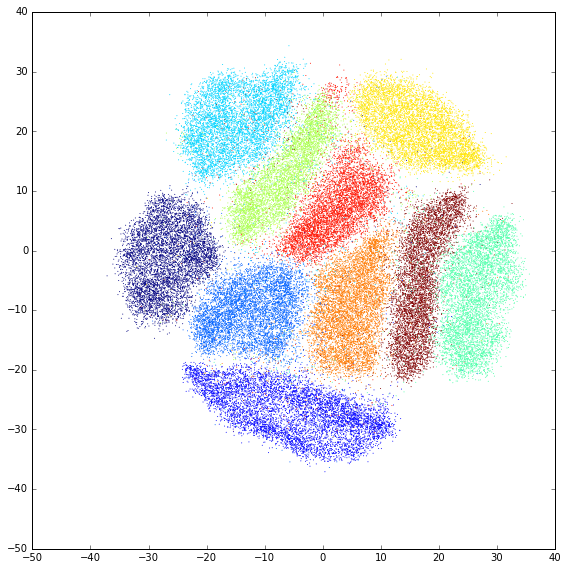

In [23]:
plot_model(conv, X_train_conv, y_train)

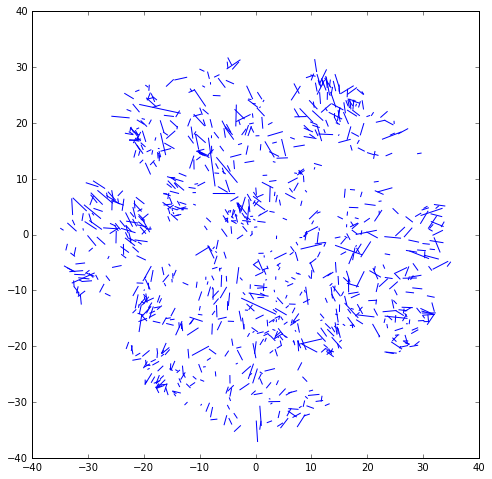

In [24]:
plot_differences(conv, X_train_conv, X_2d)